In [1]:
from noisy_zsc.game import NoisyBailLeverGame
from noisy_zsc.heuristic_learner import ArgmaxAgent, Argmaxof2Agent, StubbornAgent, argmax_of_2
from noisy_zsc.learner.PPOAgent import PPOAgent
import torch as T
import numpy as np
import matplotlib.pyplot as plt
import wandb
from copy import deepcopy
import random
from collections import deque
import pandas as pd
import csv

In [2]:
def eval_IPPO_xplay(n_games,
    env: NoisyBailLeverGame,
    agent1: PPOAgent,
    agent2: PPOAgent):

    score_list = []
    epi_list = []
    avg_score = 0
    N = 20

    for epi in range(n_games):
        obs, _ = env.reset()
        
        done = False
        score = 0
        
        epi_list.append(epi)

        while not done:
            action1, prob, val = agent1.choose_action(obs[0])
            action2, prob, val = agent2.choose_action(obs[1])
    
            reward, done = env.step(action1, action2)

            obs_ = env.get_obs()
        
            score += reward

            #agent1.remember(obs[0], action1, prob, val, reward, done)
            #agent2.remember(obs[1], action2, prob, val, reward, done)

            #if n_steps % N == 0:
            #    agent1.learn(ent_weight=config.ent_weight)
            #    agent2.learn(ent_weight=config.ent_weight)
            obs = obs_
        
        score_list.append(score)
        #print(f"episode {epi} -- score {score}")
    avg_score = np.mean(score_list)

    return avg_score


### get cross play matrix ###

def xplay_mat(sigma1, sigma2):
    sigma = 5.
    bail_payoff = 5.
    mean_payoffs = [5., 5., 5.]
    episode_length = 1

    lr = 0.00024
    clip = 0.2 # typical 0.1-0.3
    batch_size = 64
    n_epochs = 10

    n_games = 100

    env = NoisyBailLeverGame(mean_payoffs, bail_payoff, sigma, sigma1, sigma2, episode_length)
    n_actions = len(env.true_payoffs)
    obs_dim = env.obs_dim()
    
    df = pd.DataFrame(columns = ['seed1', 'seed2', 'value'])
    for seed1 in range(15):
        for seed2 in range(15):
            agent1_actor_chkpt = f"models/actor_sigma1{sigma1}_sigma2{sigma2}_seed{seed1}_1"
            agent1_critic_chkpt = f"models/critic_sigma1{sigma1}_sigma2{sigma2}_seed{seed1}_1"
            agent2_actor_chkpt = f"models/actor_sigma1{sigma1}_sigma2{sigma2}_seed{seed2}_1"
            agent2_critic_chkpt = f"models/critic_sigma1{sigma1}_sigma2{sigma2}_seed{seed2}_1"
            agent1 = PPOAgent(n_actions=n_actions, batch_size=batch_size, 
                    alpha=lr, n_epochs=n_epochs, 
                    input_dims=obs_dim)
            agent2 = deepcopy(agent1)
            agent1.load_models(agent1_actor_chkpt, agent1_critic_chkpt)
            agent2.load_models(agent2_actor_chkpt, agent2_critic_chkpt)

            score = eval_IPPO_xplay(n_games,env,agent1,agent2)
            entry = pd.DataFrame.from_dict({'seed1': [seed1], 
                'seed2': [seed2], 'value':[score]})        
            df = pd.concat([df, entry], ignore_index = True)

    return df


                

In [7]:
import os

os.chdir('../sigma_sweep/')
os.getcwd()

'/data/engs-oxfair3/bras5206/noisy-ZSC/tests/sigma_sweep'

In [8]:
df = xplay_mat(sigma1=1, sigma2=1)

episode 0 -- score 7.565982596729821
episode 1 -- score 0
episode 2 -- score 13.023644064913151
episode 3 -- score 0
episode 4 -- score 12.1039835385875
episode 5 -- score 14.906489904099509
episode 6 -- score 7.855546494458844
episode 7 -- score 16.88749282829013
episode 8 -- score 4.937926737675344
episode 9 -- score 7.7204066624364405
episode 10 -- score 8.303605546533932
episode 11 -- score 11.561471501626658
episode 12 -- score 0
episode 13 -- score 0
episode 14 -- score 6.325924218390041
episode 15 -- score 6.037839745640818
episode 16 -- score 0
episode 17 -- score 7.997524441640087
episode 18 -- score 5.544172929413972
episode 19 -- score 0
episode 20 -- score 7.372229109586266
episode 21 -- score 7.783424701968624
episode 22 -- score 4.753657160313173
episode 23 -- score 4.991109709207166
episode 24 -- score 0
episode 25 -- score 13.168359407207813
episode 26 -- score 0
episode 27 -- score 11.886152170628364
episode 28 -- score 10.22345663048369
episode 29 -- score 0
episode 3

In [9]:
df

,seed1,seed2,value
0,0,0,8.088264
1,0,1,7.736411
2,0,2,4.625768
3,0,3,7.091774
4,0,4,6.480854
...,...,...,...
220,14,10,6.568493
221,14,11,6.370645
222,14,12,7.692617
223,14,13,5.377994


/home/bras5206/.conda/envs/pytorch/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


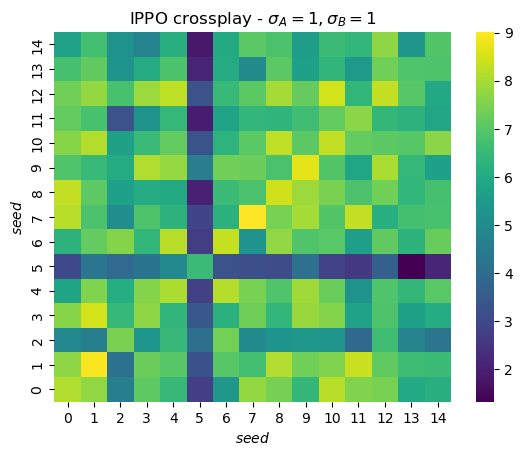

In [14]:
import seaborn as sns
pivot = df.pivot(index='seed1', columns='seed2', values='value')
ax = sns.heatmap(pivot, fmt='.1f', cmap='viridis')
ax.invert_yaxis()
plt.title(f"IPPO crossplay - $\sigma_A=1,\sigma_B=1$")
plt.xlabel("$seed$")
plt.ylabel("$seed$")
plt.savefig('IPPO_xplay_1_1.png')
plt.show()

In [15]:
df_8_8 = xplay_mat(sigma1=8, sigma2=8)
pivot = df_8_8.pivot(index='seed1', columns='seed2', values='value')
ax = sns.heatmap(pivot, fmt='.1f', cmap='viridis')
ax.invert_yaxis()
plt.title(f"IPPO crossplay - $\sigma_A=8,\sigma_B=8$")
plt.xlabel("$seed$")
plt.ylabel("$seed$")
plt.savefig('IPPO_xplay_8_8.png')
plt.show()

episode 0 -- score 1.6933543207644193
episode 1 -- score 0
episode 2 -- score 0
episode 3 -- score 6.808998523204889
episode 4 -- score 4.833188880943223
episode 5 -- score 1.364351509168209
episode 6 -- score 7.590028611432199
episode 7 -- score 0
episode 8 -- score 2.62081669669027
episode 9 -- score 4.976601441942773
episode 10 -- score 18.38012263635326
episode 11 -- score 7.330120248514065
episode 12 -- score 3.091491698007367
episode 13 -- score 5.388512795133652
episode 14 -- score 3.0009483385745384
episode 15 -- score 11.805628894410825
episode 16 -- score 3.2942436564122075
episode 17 -- score 10.81589319689159
episode 18 -- score 0.7736448547148242
episode 19 -- score 17.558100120218814
episode 20 -- score 4.011291617644808
episode 21 -- score 18.28052828666791
episode 22 -- score 1.9627487155420793
episode 23 -- score -1.2333106887814536
episode 24 -- score 0.5256342133071659
episode 25 -- score 3.5789553192627115
episode 26 -- score 10.61493634849344
episode 27 -- score 9.